In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader.data as web
import datetime as dt
from scipy.stats import lognorm
%matplotlib inline

In [3]:
start = dt.datetime(2000,4,1)
end = dt.datetime(2020,4,1)

In [4]:
df1 = web.DataReader('AMZN', 'yahoo', start, end)['Adj Close']
df2 = web.DataReader('BRK-B', 'yahoo', start, end)['Adj Close']
df3 = web.DataReader('JPM', 'yahoo', start, end)['Adj Close']
df4 = web.DataReader('VFINX', 'yahoo', start, end)['Adj Close']
df5 = web.DataReader('MCD', 'yahoo', start, end)['Adj Close']

In [5]:
portfolio = pd.concat([df1, df2, df3,df4,df5],axis=1)
portfolio.columns=['AMZN', 'BRK-B', 'JPM', 'VFINX', 'MCD']
portfolio

,AMZN,BRK-B,JPM,VFINX,MCD
Date,,,,,
2000-04-03,63.562500,35.099998,33.803940,96.289825,23.141506
2000-04-04,63.937500,36.180000,31.951305,95.575111,23.160290
2000-04-05,62.187500,36.759998,31.813177,95.110214,23.179064
2000-04-06,64.250000,37.259998,32.204529,96.026108,22.239889
2000-04-07,67.562500,36.820000,31.813177,96.983696,22.239889
...,...,...,...,...,...
2020-03-26,1955.489990,183.899994,97.110886,242.710007,167.350006
2020-03-27,1900.099976,179.660004,90.192764,234.539993,164.009995
2020-03-30,1963.949951,183.179993,92.538399,242.429993,168.130005


In [49]:
returns[returns.index.year == 2019].mean(axis=0)*100

AMZN     0.092645
BRK-B    0.045659
JPM      0.160600
VFINX    0.111292
MCD      0.056385
dtype: float64

In [6]:
returns = portfolio.pct_change(); returns

,AMZN,BRK-B,JPM,VFINX,MCD
Date,,,,,
2000-04-03,NaN,NaN,NaN,NaN,NaN
2000-04-04,0.005900,0.030769,-0.054805,-0.007423,0.000812
2000-04-05,-0.027370,0.016031,-0.004323,-0.004864,0.000811
2000-04-06,0.033166,0.013602,0.012302,0.009630,-0.040518
2000-04-07,0.051556,-0.011809,-0.012152,0.009972,0.000000
...,...,...,...,...,...
2020-03-26,0.036933,0.019006,0.069661,0.062421,0.026813
2020-03-27,-0.028325,-0.023056,-0.071239,-0.033662,-0.019958
2020-03-30,0.033603,0.019593,0.026007,0.033640,0.025120


# Annual returns each stock and average portfolio return

In [68]:
print(returns.mean(axis=0, skipna = True)*252)

port = []

for column in returns:
    port.append(returns[column].mean(axis=0, skipna = True)*252)

print('\n')
print('Annual Return of Portfolio:', sum(port)/5)

AMZN     0.299982
BRK-B    0.105150
JPM      0.121166
VFINX    0.062698
MCD      0.123665
dtype: float64


Annual Return of Portfolio: 0.1425322771488055


# Stocks’ volatility (daily returns)

Text(0, 0.5, 'daily returns')

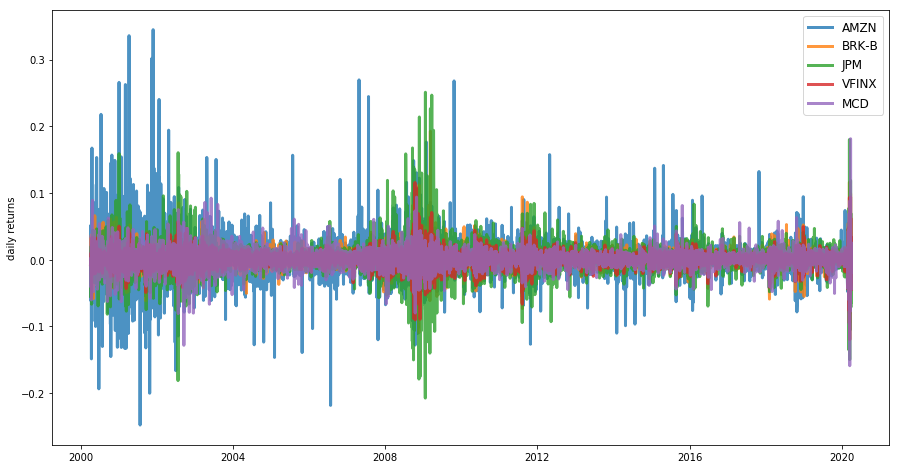

In [32]:
returns = portfolio.pct_change()

plt.figure(figsize=(15, 8))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

# Price Action over the last 20 years

Text(0, 0.5, 'Adjusted Closed Price')

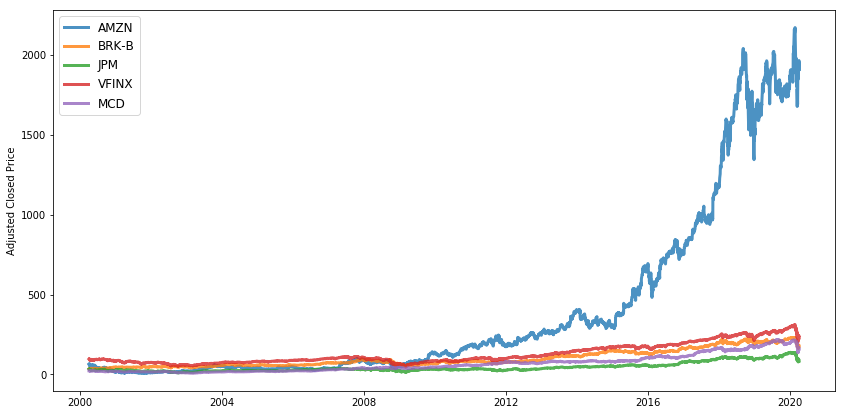

In [8]:
plt.figure(figsize=(14, 7))
for c in dfa.columns.values:
    plt.plot(dfa.index, dfa[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Adjusted Closed Price')

In [27]:
def portfolio_annual_returns(weights, mean_returns, cov_matrix):
    '''Calcutlate annual returns and standard deviation of portfolio'''
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def generate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    '''Generate portfolios with random weights'''
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annual_returns(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [26]:
# parameters
returns = portfolio.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0115

In [28]:
def mean_variance_optimimazation(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = generate_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=portfolio.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=portfolio.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Risk:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Risk Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Risk:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Risk')
    plt.title('Mean Variance Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Risk')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)



--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.17
Annualised Risk: 0.23


             AMZN  BRK-B   JPM  VFINX    MCD
allocation  29.25  30.46  0.36   0.66  39.27
--------------------------------------------------------------------------------
Minimum Risk Portfolio Allocation

Annualised Return: 0.1
Annualised Risk: 0.17


            AMZN  BRK-B   JPM  VFINX    MCD
allocation  0.39  30.51  0.28  35.78  33.03


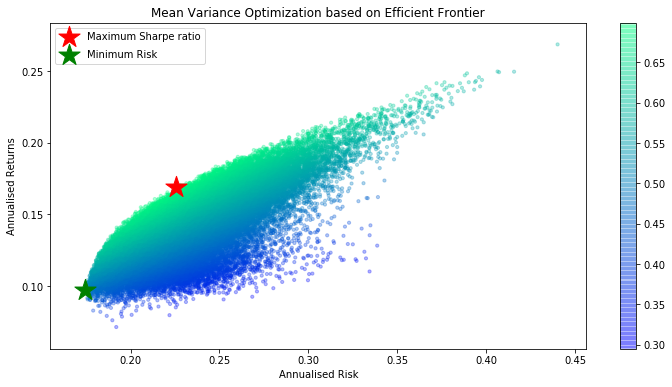

In [29]:
mean_variance_optimimazation(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [101]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [102]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [103]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [104]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=dfa.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=dfa.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.27, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.21


             AMZN  BRK-B  JPM  VFINX    MCD
allocation  24.11  30.12  0.0    0.0  45.78
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.17


            AMZN  BRK-B  JPM  VFINX    MCD
allocation   0.0  28.67  0.0  42.77  28.56


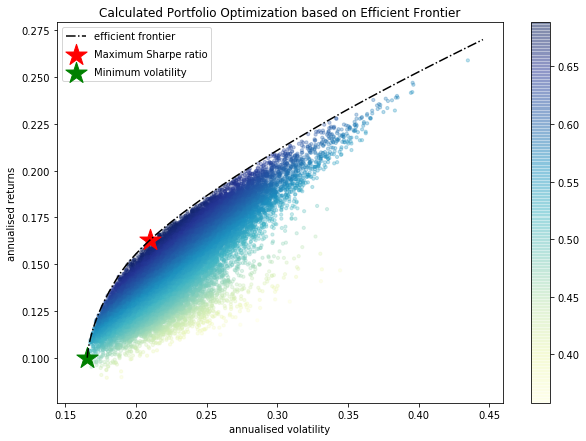

In [221]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [105]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=dfa.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=dfa.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    print( "-"*80)
    print( "Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(dfa.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print( "-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(dfa.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.3, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.21


             AMZN  BRK-B  JPM  VFINX    MCD
allocation  24.11  30.12  0.0    0.0  45.78
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.17


            AMZN  BRK-B  JPM  VFINX    MCD
allocation   0.0  28.67  0.0  42.77  28.56
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AMZN : annuaised return 0.3 , annualised volatility: 0.53
BRK-B : annuaised return 0.11 , annualised volatility: 0.22
JPM : annuaised return 0.14 , annualised volatility: 0.39
VFINX : annuaised return 0.08 , annualised volatility: 0.19
MCD : annuaised return 0.13 , annualised volatility: 0.23
---------------------------------------------------------

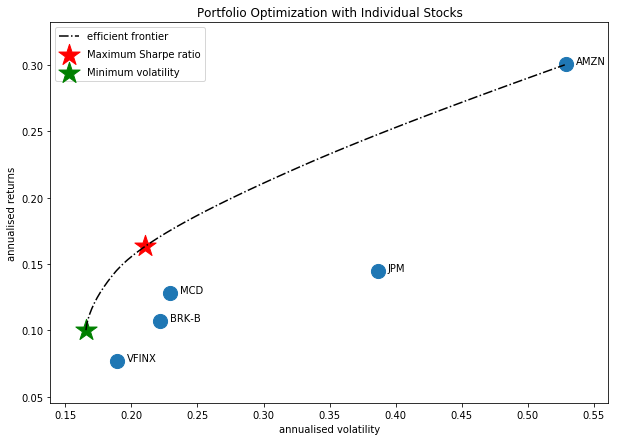

In [235]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

# Portfolio Retirement Simulation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026F0DE30748>,
      dtype=object)

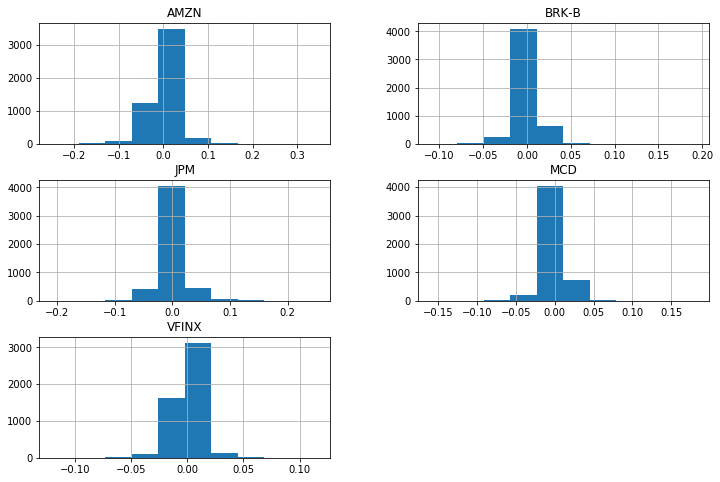

In [31]:
returns.hist(figsize=(12, 8))

In [38]:
returns

,AMZN,BRK-B,JPM,VFINX,MCD
Date,,,,,
2000-04-03,NaN,NaN,NaN,NaN,NaN
2000-04-04,0.005900,0.030769,-0.054805,-0.007423,0.000812
2000-04-05,-0.027370,0.016031,-0.004323,-0.004864,0.000811
2000-04-06,0.033166,0.013602,0.012302,0.009630,-0.040518
2000-04-07,0.051556,-0.011809,-0.012152,0.009972,0.000000
...,...,...,...,...,...
2020-03-26,0.036933,0.019006,0.069661,0.062421,0.026813
2020-03-27,-0.028325,-0.023056,-0.071239,-0.033662,-0.019958
2020-03-30,0.033603,0.019593,0.026007,0.033640,0.025120


# Returns Distribution

- Multiply the portfolio's weights and the daily returns
- The two portfolios: Max. Sharpe Ratio Portfolio, minimum risk portfolio

In [162]:
daily_returns = returns

# Maximum Sharpe Ratio Portfolio - AMZN  BRK-B   JPM  VFINX    MCD allocation; 29.25%  30.46%  0.36%   0.66%  39.27%
for ind in daily_returns.index:
    daily_returns['PortfolioReturnsMaxSharpe'] = (daily_returns['AMZN']*.2925+daily_returns['BRK-B']*.3046+ 
                                          daily_returns['JPM']*.0066+daily_returns['VFINX']*0+
                                          daily_returns['MCD']*.3927)
    
# Min Risk: S Portfolio - AMZN  BRK-B   JPM  VFINX   MCD allocation;  0.39%  30.51%  0.28%  35.78%  33.03%
for ind in daily_returns.index:
    daily_returns['PortfolioReturnsMinRisk'] = (daily_returns['AMZN']*.0039+daily_returns['BRK-B']*.3051+ 
                                          daily_returns['JPM']*.0028+daily_returns['VFINX']*.3578+
                                          daily_returns['MCD']*0.3303)

#daily_returns.mean(axis = 1).hist(figsize=(12, 5), bins=100) # distribution of portfolio's daily mean returns 

In [116]:
daily_returns

,AMZN,BRK-B,JPM,VFINX,MCD,Portfolio Returns,PortfolioReturnsMaxSharpe,PortfolioReturnsMinRisk
Date,,,,,,,,
2000-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-04,0.005900,0.030769,-0.054805,-0.007423,0.000812,0.011062,0.011055,0.006870
2000-04-05,-0.027370,0.016031,-0.004323,-0.004864,0.000811,-0.001399,-0.002833,0.003300
2000-04-06,0.033166,0.013602,0.012302,0.009630,-0.040518,-0.006456,-0.001986,-0.005624
2000-04-07,0.051556,-0.011809,-0.012152,0.009972,0.000000,0.008873,0.011403,0.000132
...,...,...,...,...,...,...,...,...
2020-03-26,0.036933,0.019006,0.069661,0.062421,0.026813,0.026904,0.027581,0.037328
2020-03-27,-0.028325,-0.023056,-0.071239,-0.033662,-0.019958,-0.022911,-0.023616,-0.025981
2020-03-30,0.033603,0.019593,0.026007,0.033640,0.025120,0.025503,0.025833,0.026515


## Comparing the distribution of returns between the two portfolios

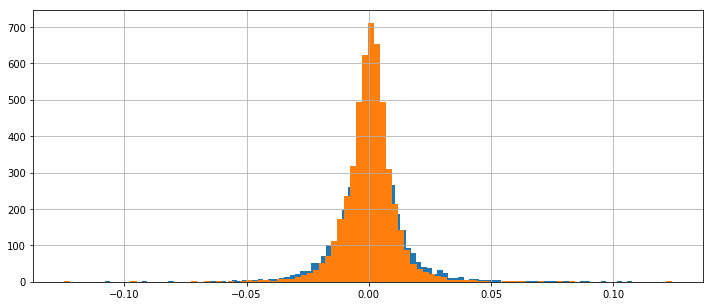

In [115]:
daily_returns['PortfolioReturnsMaxSharpe'].hist(figsize=(12, 5), bins=100) # distribution of portfolio's daily mean returns
daily_returns['PortfolioReturnsMinRisk'].hist(figsize=(12, 5), bins=100) # distribution of portfolio's daily mean returns 

In [55]:
daily_returns.mean(axis = 0) # mean daily return per stock

AMZN     0.001190
BRK-B    0.000417
JPM      0.000481
VFINX    0.000249
MCD      0.000491
dtype: float64

In [56]:
daily_returns.std(axis = 0) # st dev daily return per stock

AMZN     0.032353
BRK-B    0.013954
JPM      0.024645
VFINX    0.012428
MCD      0.014735
dtype: float64

## Running one Monte Carlo simulation with $100k initial balance

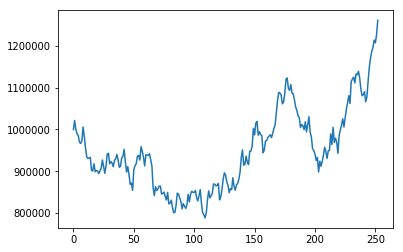

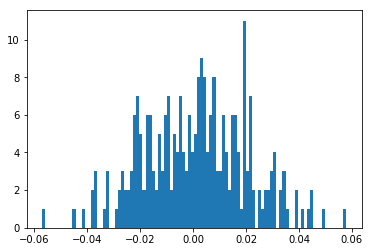

In [95]:
#create list of daily returns using random normal distribution
daily_returns_list=np.random.normal(avg_daily_return_port,std_daily_return_port,252)+1

#set starting price and create price series generated by above random daily returns
balance = 1000000

#set starting price and create price series generated by above random daily returns
price_list = [balance]
for x in daily_returns:
    price_list.append(price_list[-1]*x)
    
#Generate Plots - price series and histogram of daily returns
plt.plot(price_list)
plt.show()
plt.hist(daily_returns-1, 100) #Note that we run the line plot and histogram separately, not simultaneously.
plt.show()

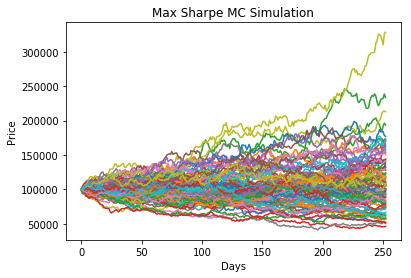

In [159]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm



Balance = 100000 

for i in range(100):
    
    daily_returns=np.random.normal(avg_daily_return_port,std_daily_return_port,252)+1
    
    #set starting price and create price series generated by above random daily returns
    price_list = [Balance]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
#show the plot of multiple price series created above
plt.title('Max Sharpe MC Simulation')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [77]:
T = 252 #Number of trading days
mu = 0.2309 #Return
vol = 0.4259 #Volatility

for i in range(100):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal(avg_daily_return_port,std_daily_return_port,252)+1

daily_returns

array([1.00317075, 1.04025513, 0.98907763, 0.98514412, 1.02180862,
       1.00323453, 1.01746729, 1.00869181, 0.97422388, 1.03535687,
       1.01770242, 0.98800805, 1.00968888, 1.00970993, 0.9912003 ,
       0.9760522 , 1.00670218, 1.00304747, 1.01026378, 1.03118195,
       0.96717663, 1.00832626, 0.9879141 , 1.01117445, 0.99681049,
       1.00990566, 1.03469691, 0.97753469, 0.95342513, 0.98963082,
       1.03023321, 0.9880032 , 0.99403007, 0.96796448, 1.0009967 ,
       0.96880314, 1.03681988, 0.98890405, 1.01632258, 1.01513131,
       0.97245765, 0.95360174, 0.95656068, 0.98921723, 1.0340959 ,
       1.00383267, 0.99894809, 0.97985851, 1.00662963, 0.97786734,
       0.99463262, 1.0289918 , 1.00698136, 0.99986902, 1.02115408,
       0.98534967, 1.01858493, 0.98495402, 0.98709162, 1.0193945 ,
       1.00610687, 1.02658088, 0.98513619, 1.01810887, 1.00456408,
       0.97329466, 0.96249042, 1.01292688, 0.99032138, 1.00628289,
       1.01367135, 0.99513609, 0.97469514, 1.00955754, 1.01923

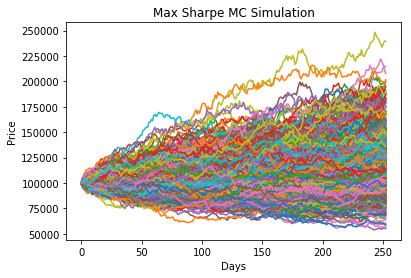

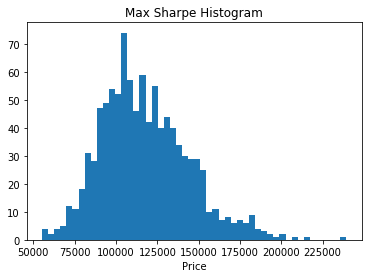

In [176]:
# mean & st dev of Max Sharpe Portfolio
maxsharpe_mean = daily_returns['PortfolioReturnsMaxSharpe'].mean(axis = 0)
maxsharpe_std = daily_returns['PortfolioReturnsMaxSharpe'].std(axis = 0)

result = []
price_list = []
Balance = 100000

for i in range(1000):
    daily_returns_list=np.random.normal(maxsharpe_mean,maxsharpe_std,252)+1
    price_list = [Balance]
    
    for x in daily_returns_list:
        price_list.append(price_list[-1]*x)
        
    plt.plot(price_list)
    result.append(price_list[-1])

plt.title('Max Sharpe MC Simulation')
plt.xlabel('Days')
plt.ylabel('Price')    
plt.show()

plt.hist(result,bins=50)
plt.title('Max Sharpe Histogram')
plt.xlabel('Price')
plt.show()

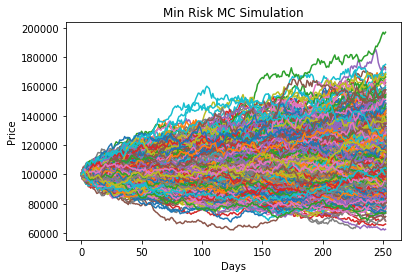

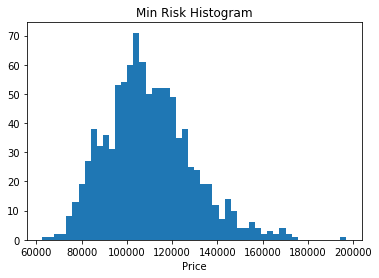

In [177]:
# mean & st dev of Max Sharpe Portfolio
minrisk_mean = daily_returns['PortfolioReturnsMinRisk'].mean(axis = 0)
minrisk_std = daily_returns['PortfolioReturnsMinRisk'].std(axis = 0)

result2 = []
price_list2 = []

Balance = 100000

for i in range(1000):
    daily_returns_list2=np.random.normal(minrisk_mean,minrisk_std,252)+1
    price_list2 = [Balance]
    
    for x in daily_returns_list2:
        price_list2.append(price_list2[-1]*x)
        
    plt.plot(price_list2)
    result2.append(price_list2[-1])

plt.title('Min Risk MC Simulation')
plt.xlabel('Days')
plt.ylabel('Price')    
plt.show()

plt.hist(result2,bins=50)
plt.title('Min Risk Histogram')
plt.xlabel('Price') 
plt.show()

In [182]:
mean1 = sum(result) / len(result)
var1 = sum([((x - mean1) ** 2) for x in result]) / len(result) 
std1 = var1 ** 0.5

mean2 = sum(result2) / len(result2)
var2 = sum([((x - mean2) ** 2) for x in result2]) / len(result2) 
std2 = var2 ** 0.5

print('Max Sharpe Porfolio: mean:{} , standard deviation:{}'.format(round(mean1,2),round(std1,2)))
print('Min Risk Porfolio: mean:{} , standard deviation:{}'.format(round(mean2,2),round(std2,2)))

Max Sharpe Porfolio: mean:117463.5 , standard deviation:26513.67
Min Risk Porfolio: mean:109832.84 , standard deviation:18988.26
